In [421]:
# Common Imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num

# Data Import Module
%run ./Module_DataImport.ipynb

# Data Visualization Module
%run ./Module_DataVisualization.ipynb

# Data Derivatives Module
%run ./Module_DataDerivatives.ipynb

## Deployment Information
In the code cell are variables that can be tuned based on the deployment, they are described in more detail below:
- student_list: a integer list of the students included in this study. Valid student numbers are between 2 and 9, inclusive.
- start_date: the first date that you would like to include in the summary. The earliest date that can be chosen that will ensure at least one student has data is 03/11/2019.
- end_date: the last date to include in the summary. No more data are available after 04/15/2019.

The start and end dates are defaulted to the earliest and latest dates, respectively, given in the description above. 

In [410]:
student_list = np.arange(2,10,1)
start_date = '04/01/2019'
end_date = '04/04/2019'
# Getting the number of hours
time_diff = datetime.strptime(end_date, '%m/%d/%Y') - datetime.strptime(start_date, '%m/%d/%Y')
num_hours = int(divmod(time_diff.total_seconds(),3600)[0])+24 # add 24 because we import all of the last day

## Data Import

### Indoor Environmental Quality Data
In the code cell below, the indoor environmental quality data is imported from the ```beacon_data``` directory available for Students 2 through 9. The variables include:
1. Temperature
2. Relative Humidity$^1$
3. PM2.5

The functions for importing the data are stored in the ```Module_DataImport.pynb``` notebook in the same directory as this master notebook. 

$^1$Temperature and Relative Humidity are imported together and stored in the same dataframe. Collectively, they are referred to as "thermal comfort"

In [411]:
TC_byStudent = pd.Series()
Concentration_byStudent = pd.Series()
for n in student_list:
    print()
    print('Importing IEQ Data for: Student',n)
    print('\nImporting Thermal Comfort Data...')
    TC_temp = ieqImport(str(n),'sht31d',['time','rh','temp'],'all',start_date,end_date)
    if len(TC_temp) < 5*num_hours: # We should get at least 5 data points per hour
        print('\tInsufficient Data - not importing')
    else:
        TC_byStudent['Student' + str(n)] = TC_temp
        print('\tImport Complete')
        
    print('\nImporting PM2.5 Concentration Data...')
    Concentration_temp = ieqImport(str(n),'pms5003',['time','PM2.5'],[0,2],start_date,end_date)
    if len(Concentration_temp) < 5*num_hours: # We should get at least 5 data points per hour
        print('\tInsufficient Data - not importing')
    else:
        Concentration_byStudent['Student' + str(n)] = Concentration_temp
        print('\tImport Complete')


Importing IEQ Data for: Student 2

Importing Thermal Comfort Data...
	No data from this deployment range
	Insufficient Data - not importing

Importing PM2.5 Concentration Data...
	No data from this deployment range
	Insufficient Data - not importing

Importing IEQ Data for: Student 3

Importing Thermal Comfort Data...
	Number of datapoints: 479
	Insufficient Data - not importing

Importing PM2.5 Concentration Data...
	Number of datapoints: 71
	Insufficient Data - not importing

Importing IEQ Data for: Student 4

Importing Thermal Comfort Data...
	Number of datapoints: 860
	Import Complete

Importing PM2.5 Concentration Data...
	Number of datapoints: 84
	Insufficient Data - not importing

Importing IEQ Data for: Student 5

Importing Thermal Comfort Data...
	Number of datapoints: 486
	Import Complete

Importing PM2.5 Concentration Data...
	No data from this deployment range
	Insufficient Data - not importing

Importing IEQ Data for: Student 6

Importing Thermal Comfort Data...
	Number o

### Sleep Quality Data
There are two types of sleep quality data, gathered from different sources:
1. Sleep Stages from Fitbit
2. Perceived Sleep Quality from Beiwe EMA Surveys

Both datasets are imported below in the code cell.

In [412]:
SS_byInd = pd.Series()
PSQ_byInd = pd.Series()
for n in student_list:
    print('Importing Sleep Quality Data for: Student',n)
    SS_byInd['Student' + str(n)] = fitbitImport(str(n),'S' + str(n) + '_SleepStages.csv',['Time','ShortWakes','Stage_Label'],[1,3,4],start_date,end_date)

Importing Sleep Quality Data for: Student 2
	Number of datapoints: 631
Importing Sleep Quality Data for: Student 3
	Number of datapoints: 730
Importing Sleep Quality Data for: Student 4
	Number of datapoints: 3097
Importing Sleep Quality Data for: Student 5
	No data from this deployment range
Importing Sleep Quality Data for: Student 6
	No data from this deployment range
Importing Sleep Quality Data for: Student 7
	No data from this deployment range
Importing Sleep Quality Data for: Student 8
	Number of datapoints: 3108
Importing Sleep Quality Data for: Student 9
	No data from this deployment range


## Single Variable Data Visualization
Below are visualizations that incorporate one variable.

### PM2.5
There are three main PM2.5 Concentration figures:
1. Time Series showing daily PM2.5 concentrations in their home
2. Time Series showing daily AQI for PM2.5 in their home
3. Bar Chart showing daily median concentrations in their home

#### PM2.5 Concentration Profile

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


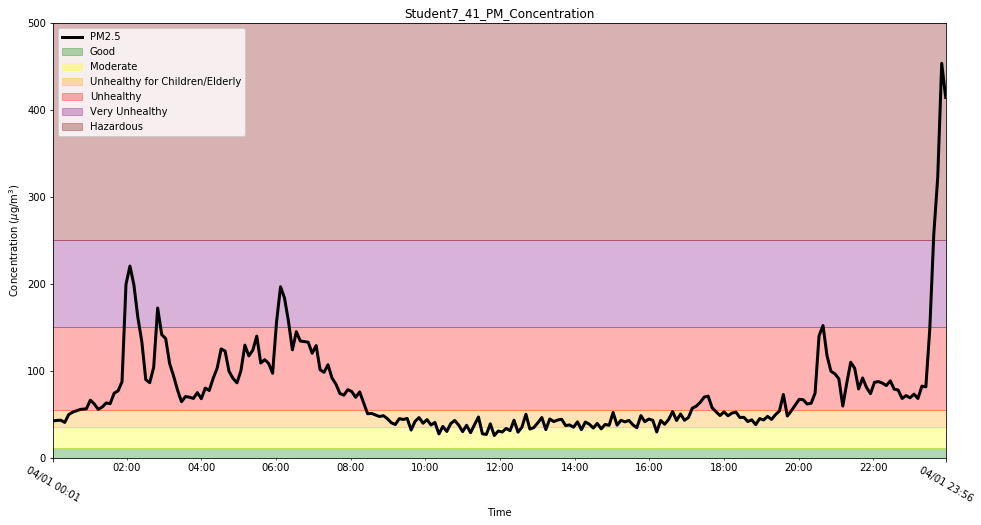

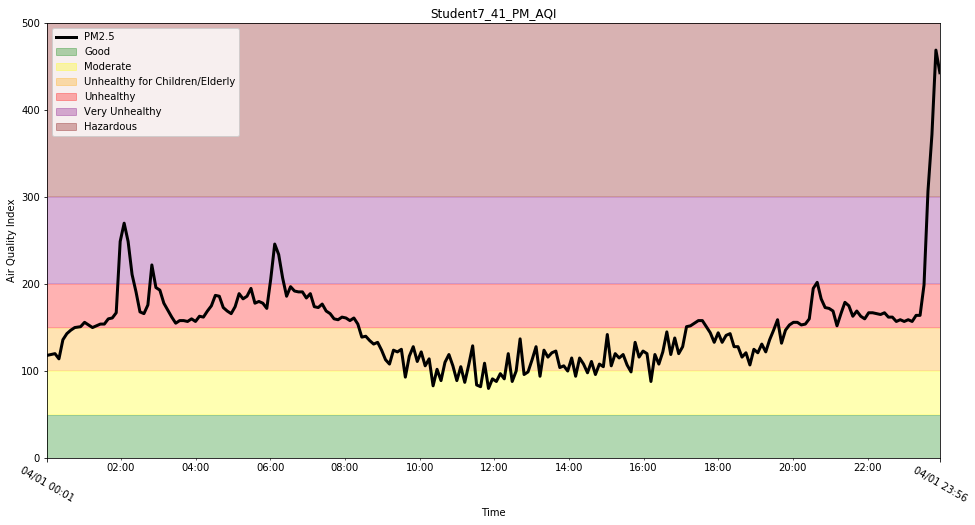

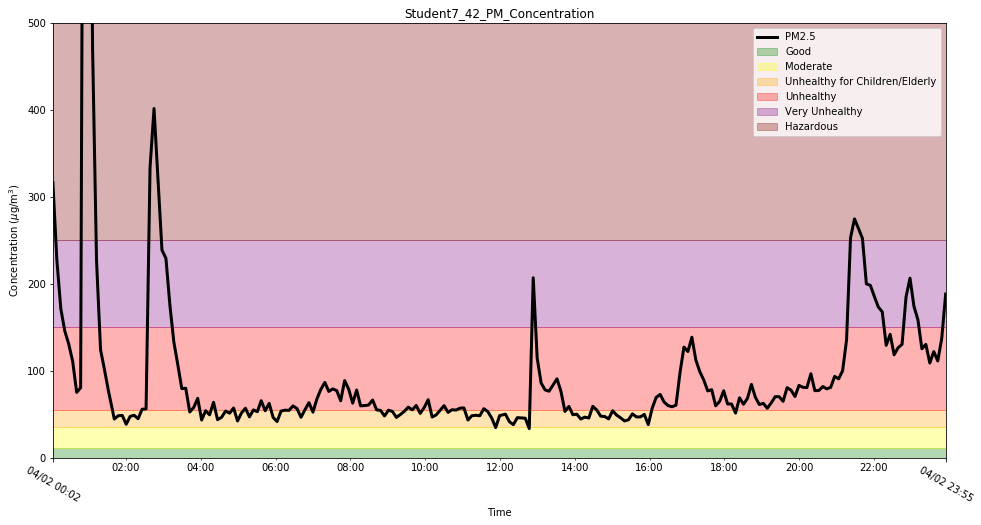

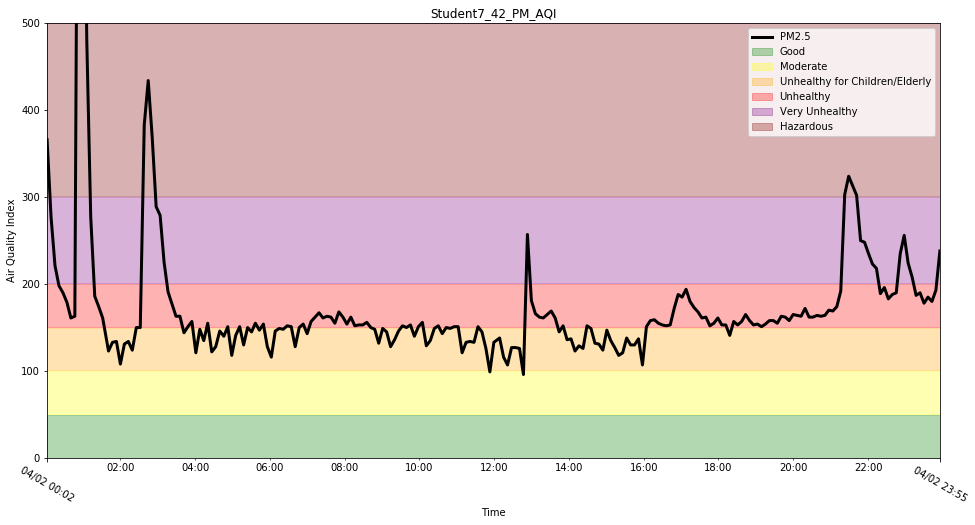

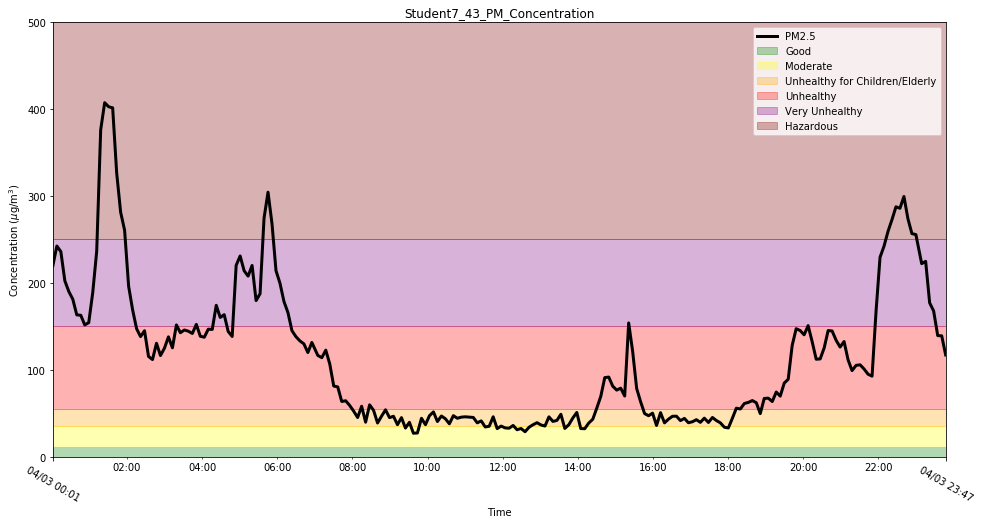

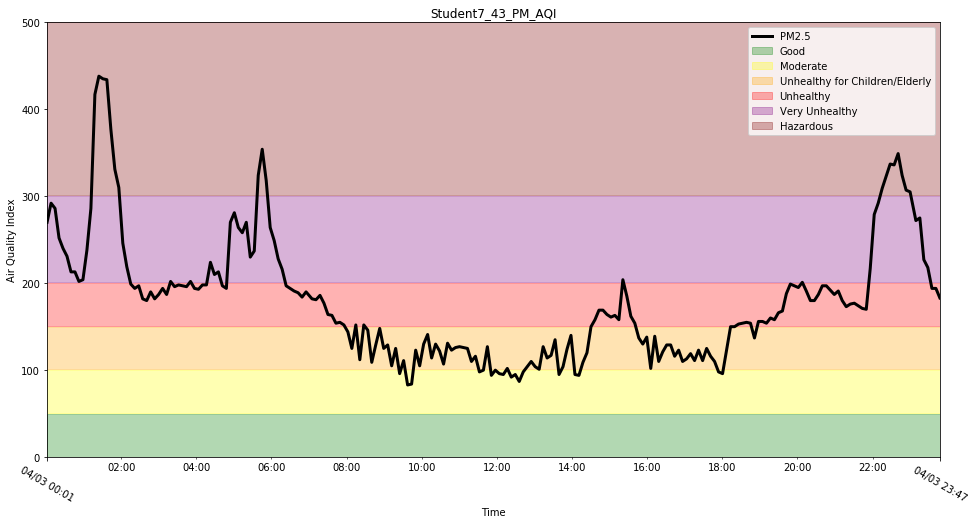

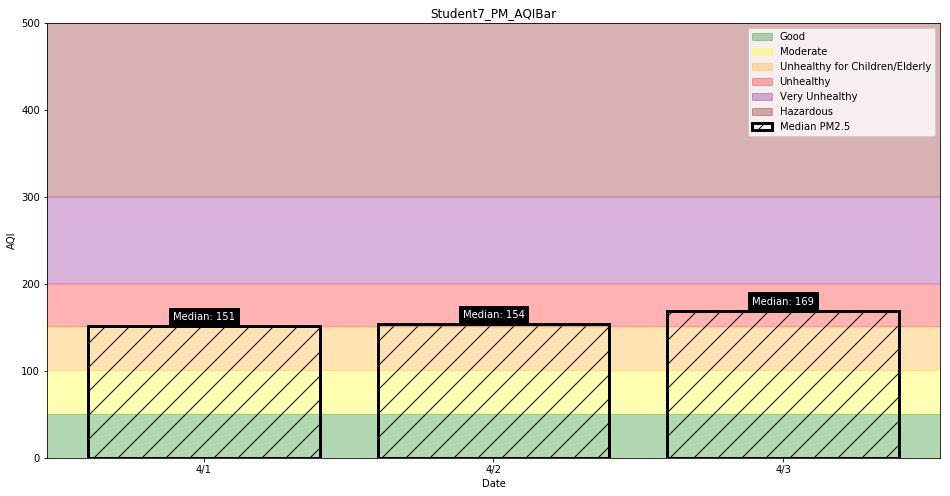

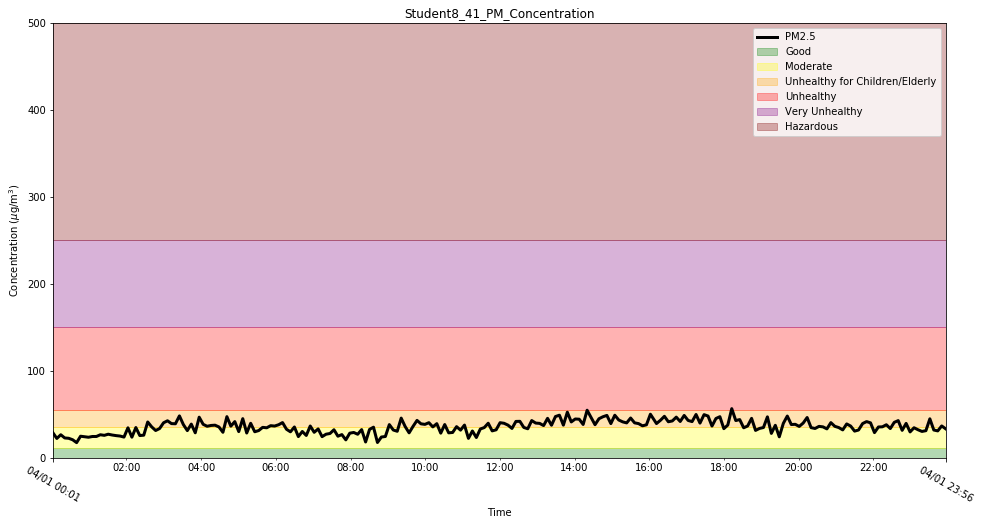

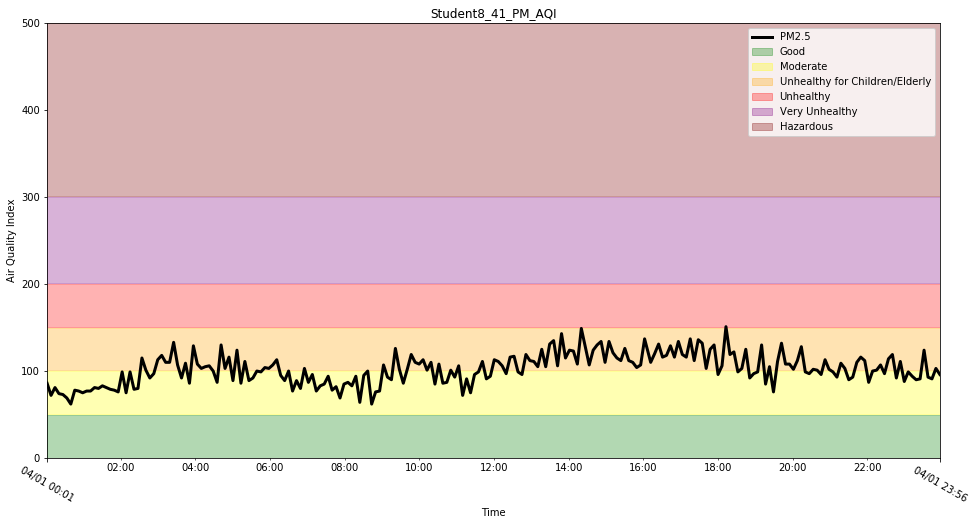

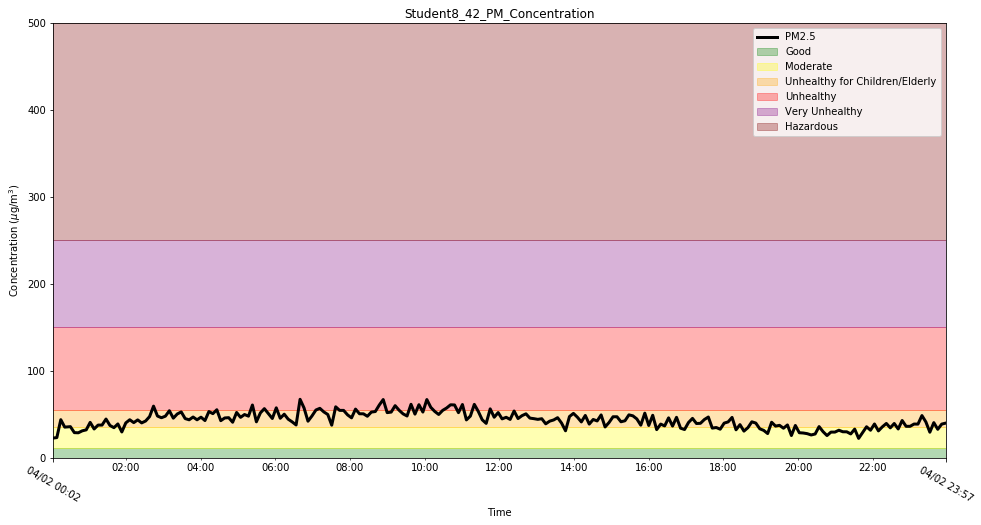

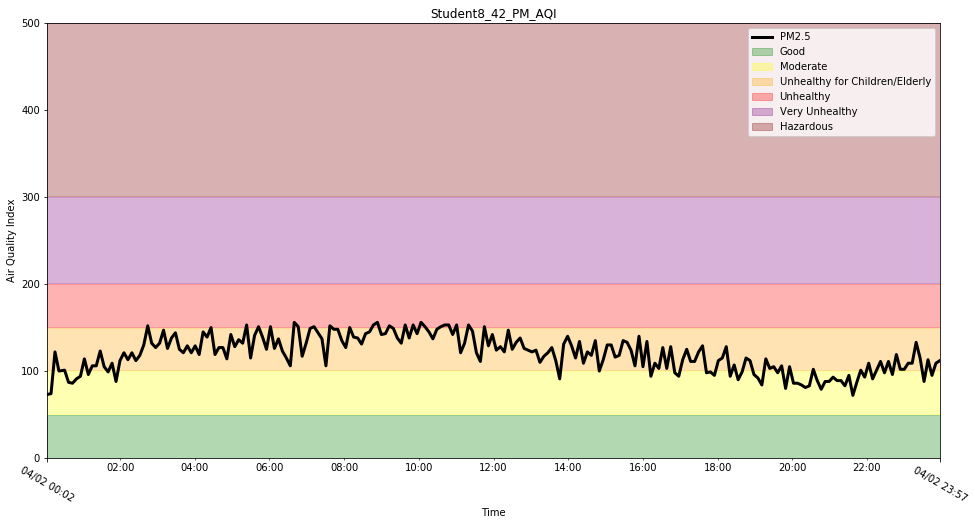

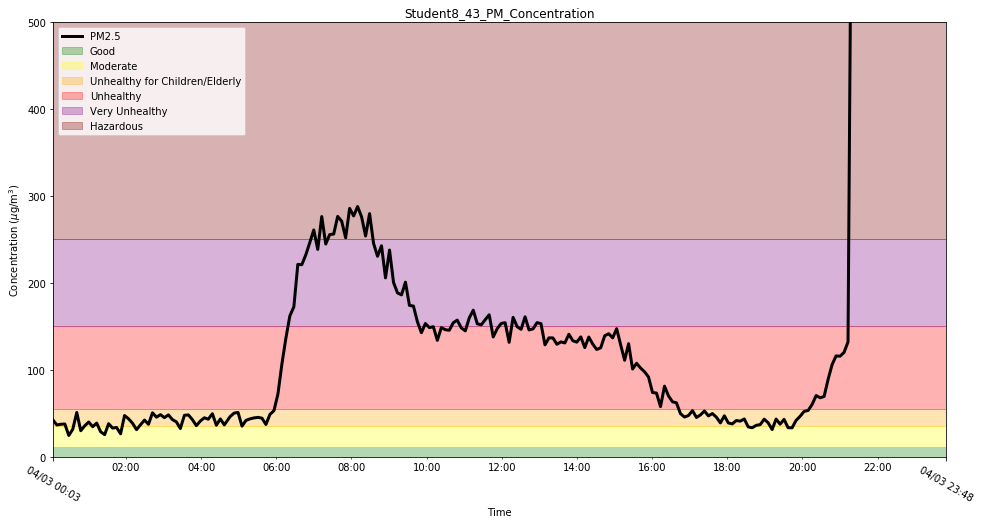

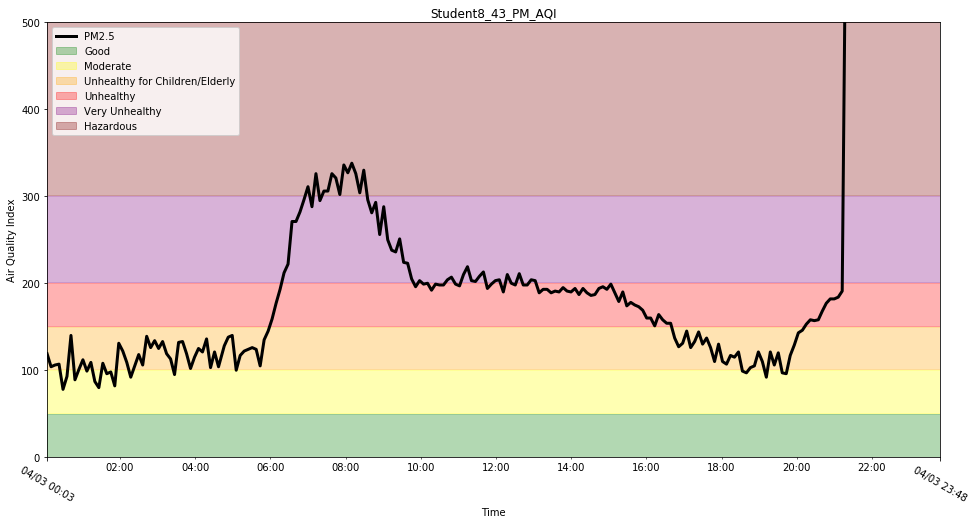

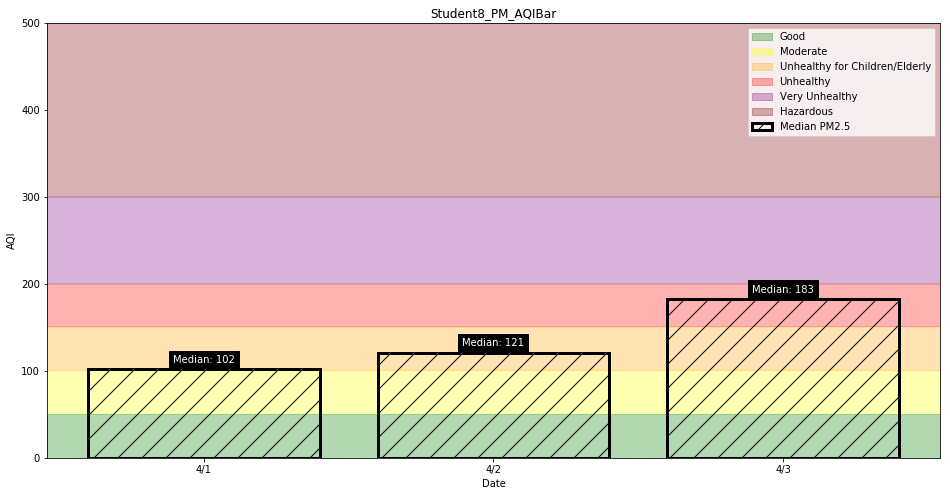

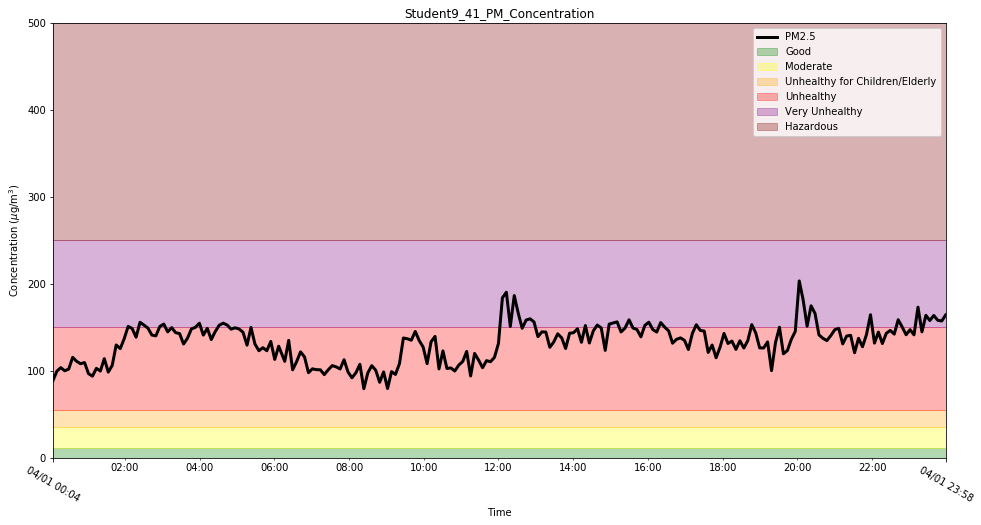

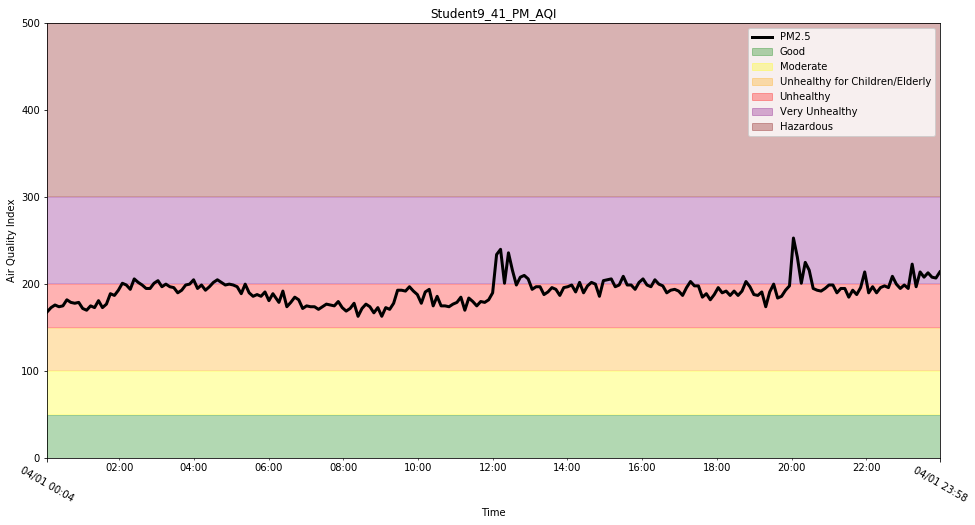

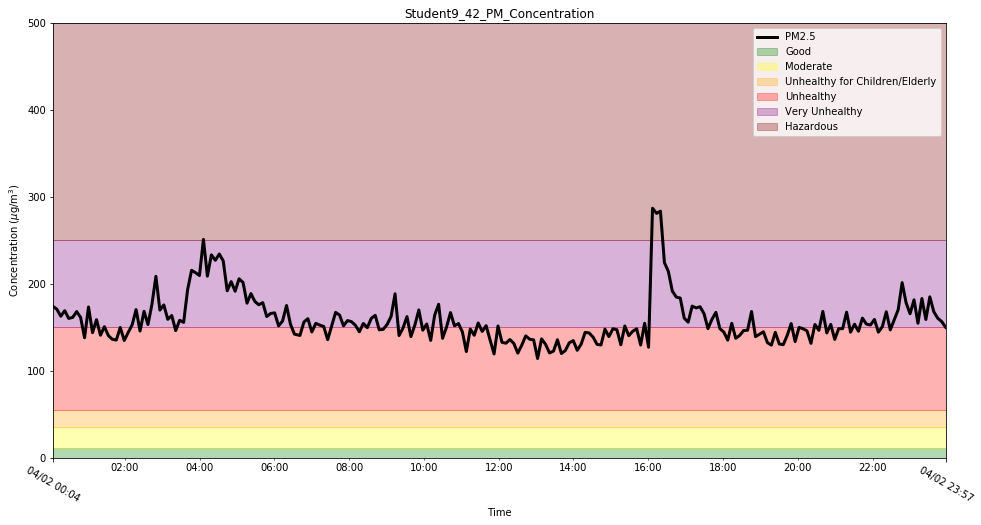

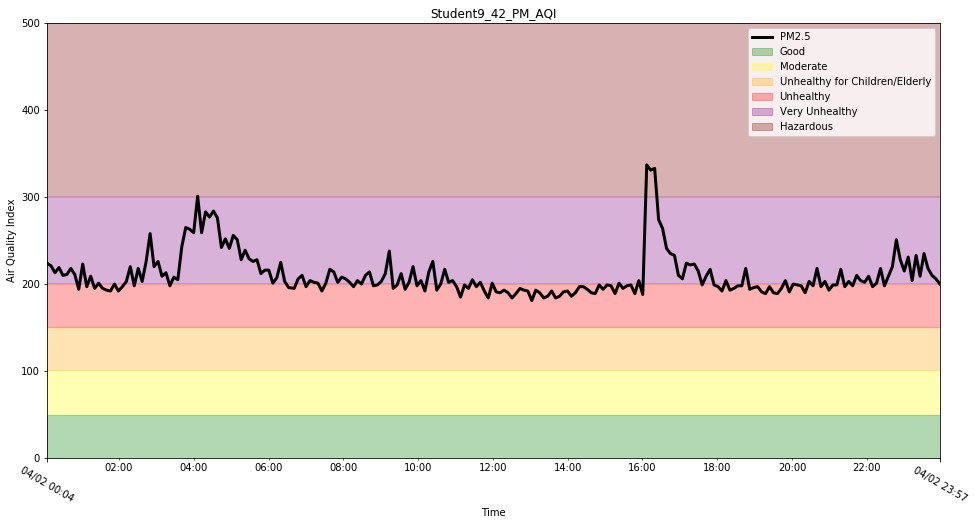

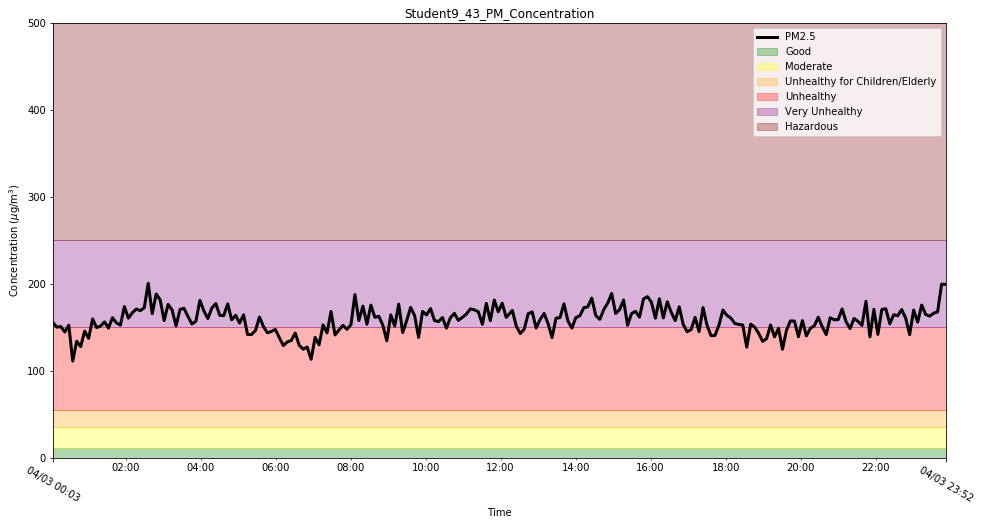

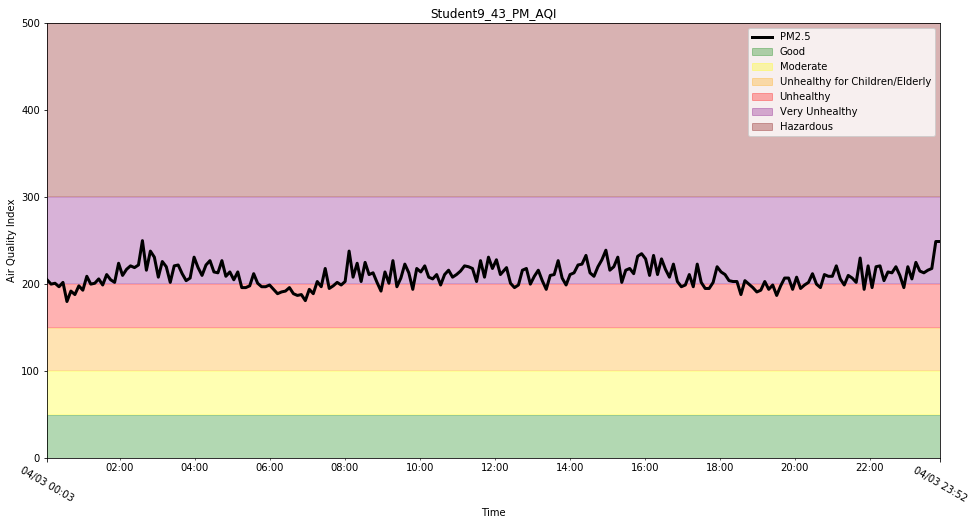

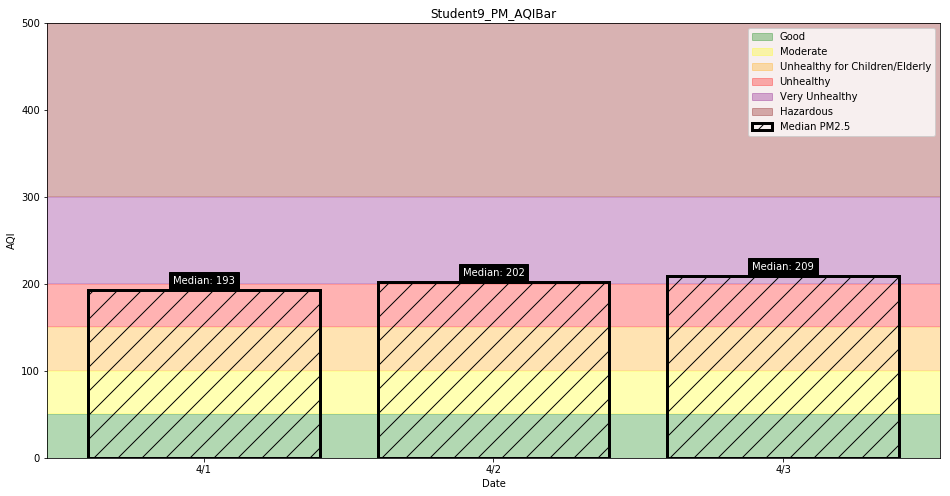

In [424]:
# Looping through all the imported data
for name in Concentration_byStudent.index:
    ## Created new columns in the dataframe that store the month and date
    Concentration_byStudent[name]['Month'] = Concentration_byStudent[name].index.month        
    Concentration_byStudent[name]['Day'] = Concentration_byStudent[name].index.day
    ## Splitting the dataframe by the month and day to get a dataframe per day
    agg = Concentration_byStudent[name].groupby(['Month','Day'])
    
    ## Looping through the individual's days of data and plotting
    index = 0
    medians = []
    date_list = []
    for group in agg:
        ### Converting the group into a dataframe
        group = pd.DataFrame(data=group[1])
        ### Plotting Concentration profile
        getFinePMTimeSeries(group.index,group['PM2.5'],'Concentration ($\mu$g/m$^3$)',index+1)
        saveFigure(name + '_' + str(group.index[0].month) + str(group.index[0].day) + '_PM_Concentration','Figures/')
        ### Plotting AQI profile
        plotFinePMTimeSeries(group.index,getAQI(group['PM2.5']),'Air Quality Index',index+1)
        saveFigure(name + '_' + str(group.index[0].month) + str(group.index[0].day) + '_PM_AQI','Figures/')
        ###
        medians.append(group['PM2.5'].median())
        date_list.append(group.index[0])
        index += 1
        
    plotFinePMMedian(date_list,getAQI(medians))
    saveFigure(name + '_PM_AQIBar','Figures/')

### Sleep Stages/Quality
There are two main Sleep Quality figures:
1. Bar Chart showing percent of time spent in each sleep stage.
    - Sleep Efficiency grade is also placed on the bar chart.
    - The following blurb should accompany the figure:
        
> The percent of time adults should spend in each of the three sleep stages is shown below:
> - Awake: 5%- 20%
> - REM: 13% - 23%
> - Non-REM: 52% - 83%
>
> Grades for sleep efficiency are explained below:
> - A: **Better than average** - 90% to 100% of the time you spend in bed, you are asleep. 
> - B: **Average** - 80% to 90% of the time you spend in bed, you are asleep. Most adults have sleep efficiencies around 85%. 
> - C: **Below Average** - 70% to 80% of the time you spend in bed, you are asleep. You should seek out ways to improve your sleep efficiency. Even minor improvements can lead to large health benefits.
> - D: **Worrisome** - 70% to 80% of the time you spend in bed, you are asleep. Poor sleep can lead to deteriorating health. Try to remove noises and light from your sleep environment and power down electronics at least 30 minutes before bed. 
> - F: **Dangerous** - 70% or less of the time you spend in bed, you are asleep. You might be suffering from differeny types of sleep apnoea. You should seek medical advice at your next check-up. 
        
2. Grouped bar chart showing the percentage of time spent in each sleep stage with a hashed area showing the recommended adult percentages. 

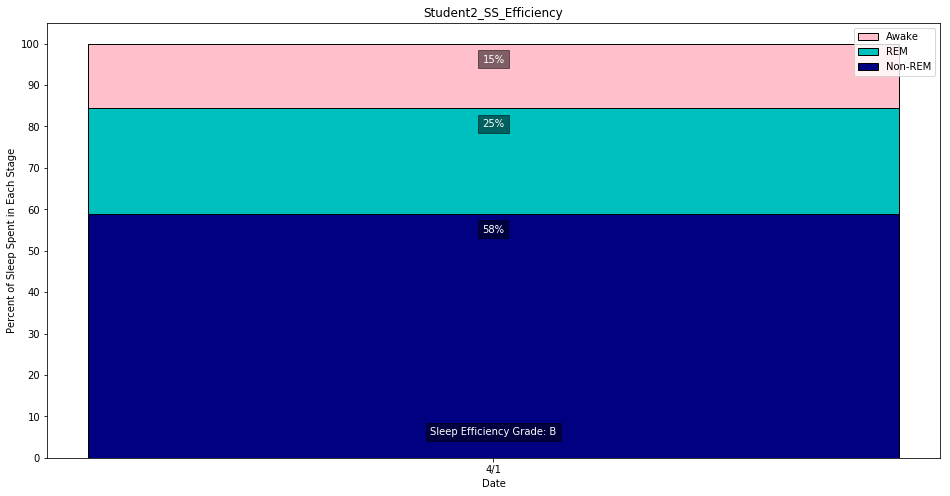

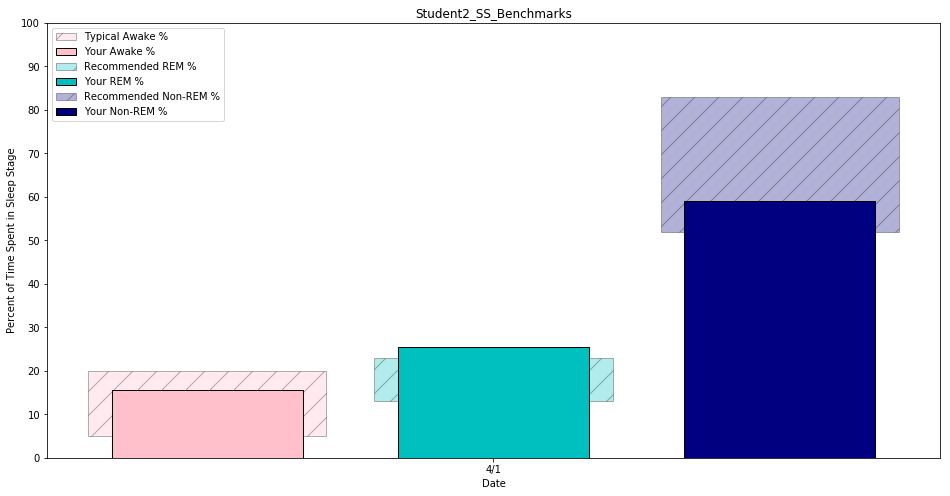

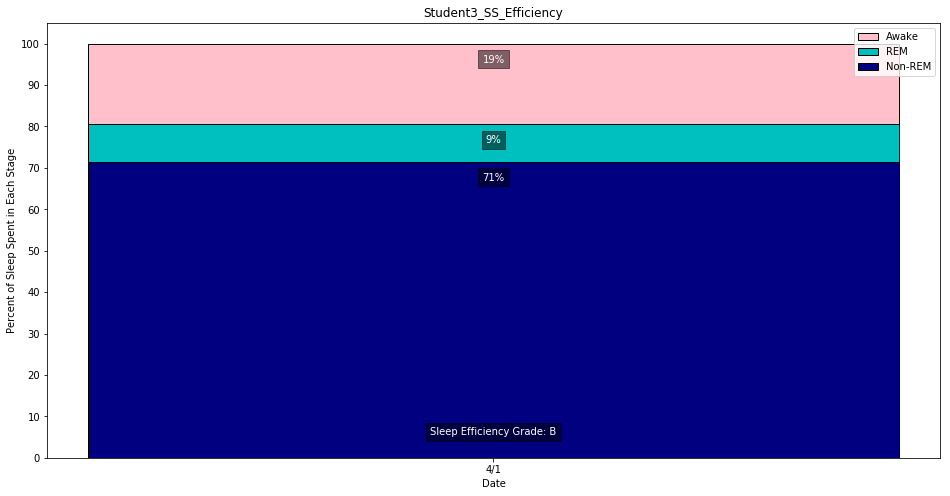

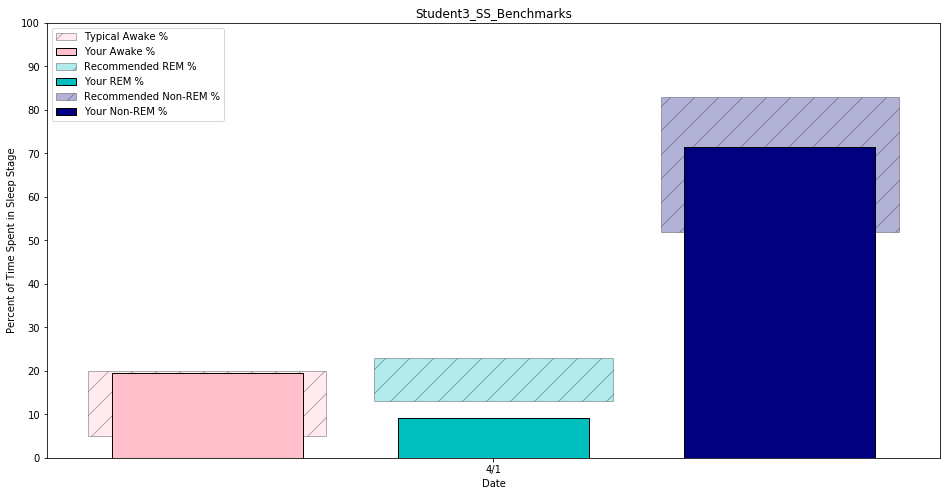

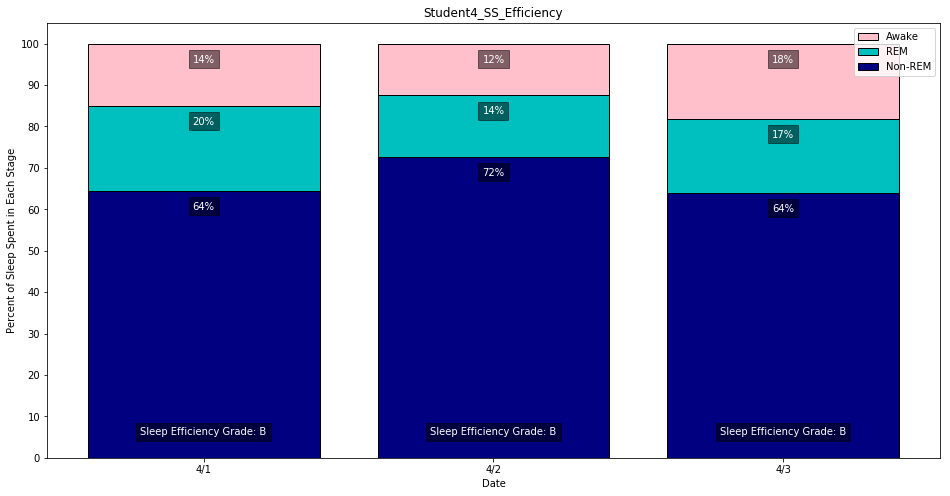

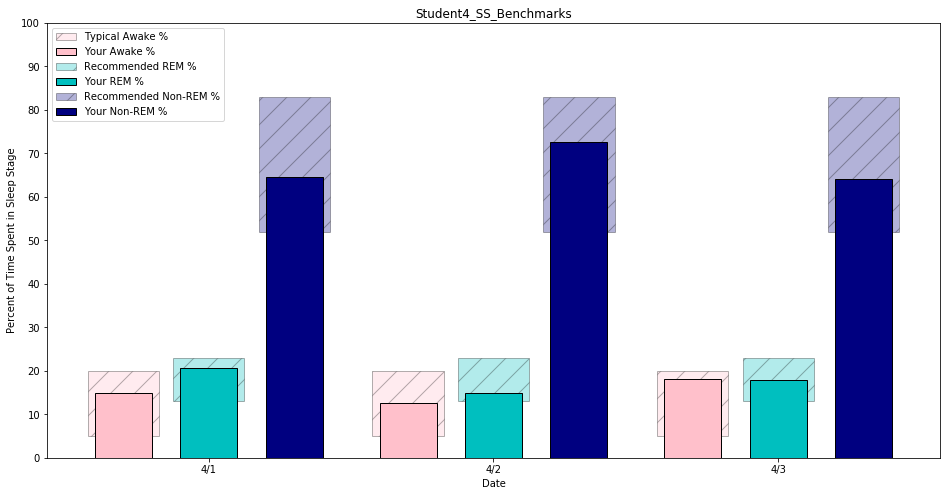

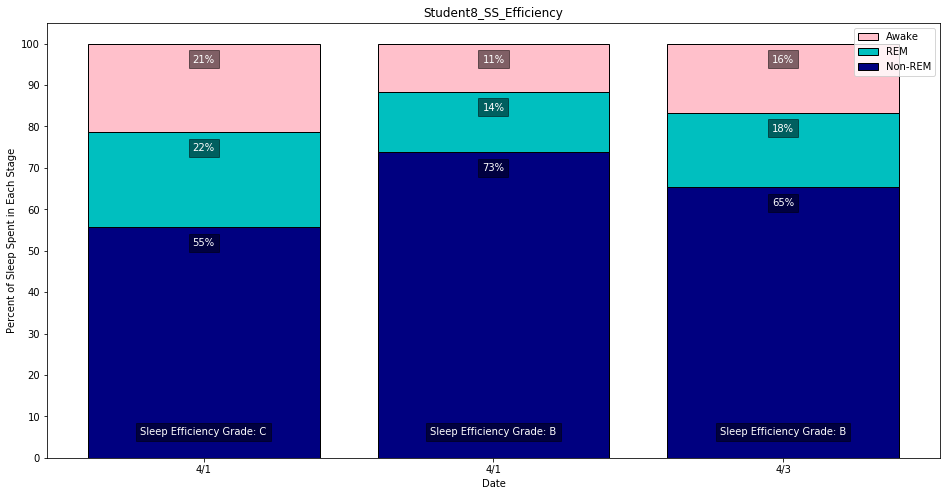

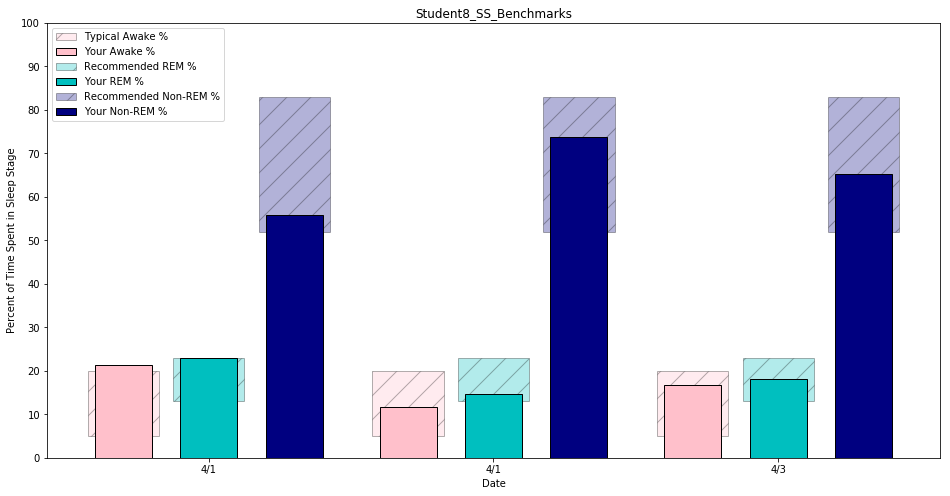

In [425]:
SM_byInd = pd.Series()
for name in SS_byInd.index:
    if len(SS_byInd[name]) > 0:
        # Get various sleep matrics and store them in a new series
        SM_byInd[name] = getSleepMetrics(SS_byInd[name])
        SM_byInd[name] = getSleepEfficiencyGrade(SM_byInd[name])
        # Plot Percentages of Sleep Stages
        getSleepStagePercentages(SM_byInd[name])
        saveFigure(name + '_SS_Efficiency','Figures/')
        # Plot Benchmarks for Sleep Stages
        getSleepStageBenchmarks(SM_byInd[name])
        saveFigure(name + '_SS_Benchmarks','Figures/')